In [224]:
#  Imports
# ----------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [225]:

import sys
print(sys.executable)


c:\Users\POWER\AppData\Local\Programs\Python\Python313\python.exe


In [226]:
data = pd.read_csv('../data/Thyroid_Diff.csv')

In [227]:
df = data.copy()

In [228]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

,Age
count,383.000000
mean,40.866841
std,15.134494
min,15.000000
25%,29.000000
50%,37.000000
75%,51.000000
max,82.000000


In [229]:
sns.set(style="whitegrid")

In [230]:
df = df.rename(columns={
    "Age": "age",
    "Gender": "gender",
    "Smoking": "smoking_status",
    "Hx Smoking": "smoking_history",
    "Hx Radiothreapy": "radiotherapy_history",
    "Thyroid Function": "thyroid_function",
    "Physical Examination": "physical_exam",
    "Adenopathy": "adenopathy",
    "Pathology": "pathology",
    "Focality": "focality",
    "Risk": "risk_level",
    "T": "tumor_size_T",
    "N": "lymph_nodes_N",
    "M": "metastasis_M",
    "Stage": "cancer_stage",
    "Response": "treatment_response",
    "Recurred": "recurrence"
})


Target Encoding

In [231]:
df['recurrence'] = df['recurrence'].map({'No':0, 'Yes':1})

Feature Lists

In [232]:
# Ordinal features
ordinal_cols = [
    'tumor_size_T', 'lymph_nodes_N', 'metastasis_M',
    'cancer_stage', 'risk_level', 'treatment_response'
]

In [233]:
# Nominal categorical features
nominal_cols = [
    'gender', 'smoking_status', 'smoking_history',
    'radiotherapy_history', 'thyroid_function', 'focality',
    'adenopathy', 'pathology'
]

In [234]:
# Numerical features
num_cols = ['age']


In [235]:
X = df[ordinal_cols + nominal_cols + num_cols]
y = df['recurrence']

In [236]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [237]:
ordinal_mapping = {
    'tumor_size_T': {'T1a':1,'T1b':2,'T2':3,'T3a':4,'T3b':5,'T4a':6,'T4b':7},
    'lymph_nodes_N': {'N0':0,'N1a':1,'N1b':2},
    'metastasis_M': {'M0':0,'M1':1},
    'cancer_stage': {'I':1,'II':2,'III':3,'IVA':4,'IVB':5},
    'risk_level': {'Low':1,'Intermediate':2,'High':3},
    'treatment_response': {'Excellent':1,'Indeterminate':2,'Biochemical Incomplete':3,'Structural Incomplete':4}
}

for col, mapping in ordinal_mapping.items():
    X_train[col] = X_train[col].map(mapping)
    X_test[col] = X_test[col].map(mapping)


In [238]:
X_train = pd.get_dummies(X_train, columns=nominal_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=nominal_cols, drop_first=True)

# Make sure columns match
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


Random Forest Model

In [239]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


In [240]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.91      0.95        22

    accuracy                           0.97        77
   macro avg       0.98      0.95      0.97        77
weighted avg       0.97      0.97      0.97        77

ROC-AUC: 0.9917355371900827


XGBoost

In [241]:
numerical_cols = ['age']
categorical_cols = [col for col in X_train.columns if col not in ordinal_mapping and col != 'age']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [242]:
from xgboost import XGBClassifier

xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=int(y_train.value_counts()[0]/y_train.value_counts()[1]),
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])


In [243]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:,1]


c:\Users\POWER\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:58:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.90      0.82      0.86        55
           1       0.63      0.77      0.69        22

    accuracy                           0.81        77
   macro avg       0.76      0.80      0.78        77
weighted avg       0.82      0.81      0.81        77

ROC-AUC: 0.8776859504132232


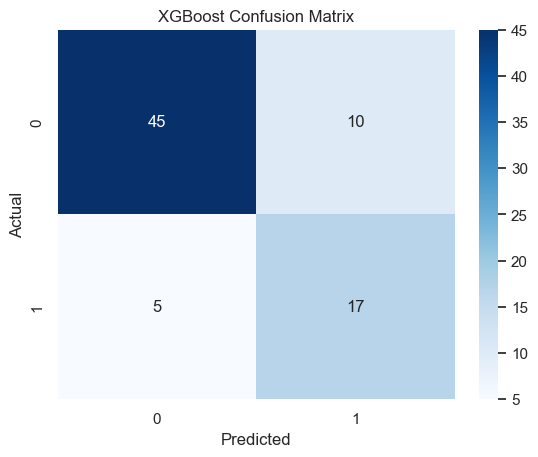

In [244]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
